In [4]:
!pip install tensorflow

!pip install opencv-python matplotlib

In [6]:
!pip install tensorflow[and-cuda]

In [310]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [312]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten


In [23]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
 tf.config.experimental.set_memeory_growth(gpu,True)

In [31]:
for gpu in gpus:
    print(gpu)
print("hello")   

hello


In [314]:
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

In [316]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [318]:
# http://vis-www.cs.umass.edu/lfw/
import uuid

In [320]:
uuid.uuid1()

UUID('43b41f1d-4f10-11ef-a017-e8fb1c4760ea')

In [43]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[200:450,200:450,:]
    if cv2.waitKey(1) & 0XFF == ord('a'): #for anchor
        #creates file pah and writes
        imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    if cv2.waitKey(1) & 0XFF == ord('p'):
         imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
         cv2.imwrite(imgname,frame)
    cv2.imshow('Image Collection',frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

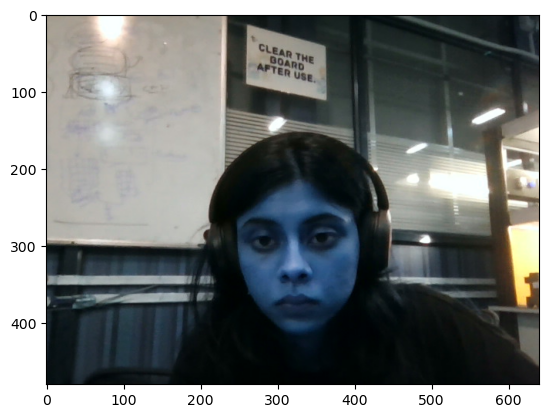

In [18]:
plt.imshow(frame)

In [20]:
frame.shape


(480, 640, 3)

In [30]:
frame[:250,:250,:].shape

(250, 250, 3)

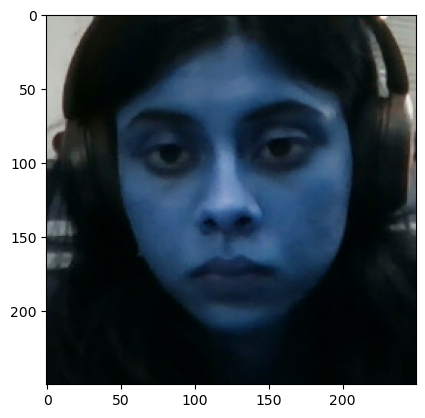

In [32]:
plt.imshow(frame[200:450,200:450,:])

In [322]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [47]:
os.listdir('lfw')

['Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abbas_Kiarostami',
 'Abba_Eban',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_al-Attiyah',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullatif_Sener',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adelina_Avila',
 'Adel_Al-Jubeir',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adrien_Brody',
 'Afton_S

In [328]:
#now to process the data
#get directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [329]:
#resize and shit
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(100,100))
    img = img/255.0

    return img
    

In [555]:
#nw create labelled dataset
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [557]:
data


<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [559]:
samples = data.as_numpy_iterator()


In [561]:
samples.next()

(b'data\\anchor\\d29af094-4e4e-11ef-9245-e8fb1c4760ea.jpg',
 b'data\\positive\\f525824c-4e4e-11ef-8a0d-e8fb1c4760ea.jpg',
 1.0)

In [563]:
#build train and test

In [565]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [567]:
data = data.map(lambda anchor_img, other_img, label: preprocess_twin(anchor_img, other_img, label))
data=data.cache()
data=data.shuffle(buffer_size = 1024)

In [569]:
data


<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [261]:
for input_img, validation_img, label in data.take(1):
    print(input_img.shape, validation_img.shape, label.shape)

(100, 100, 3) (100, 100, 3) ()


In [85]:
samples = data.as_numpy_iterator()

In [89]:
samp = samples.next()

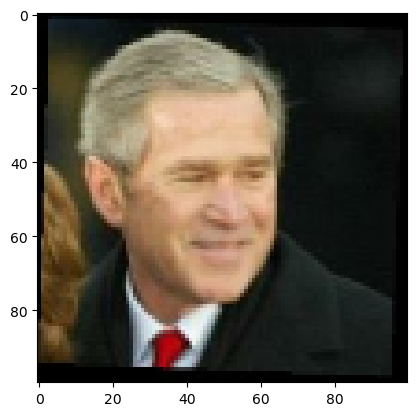

In [95]:
plt.imshow(samp[1])

In [101]:
round(len(data)*.7)

420

In [571]:
train_data=data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [573]:
train_samples = train_data.as_numpy_iterator()

In [575]:
train_sample = train_samples.next()

In [508]:
len(train_sample[0])

16

In [577]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))

In [579]:
test_data = test_data.batch(16)
train_data = train_data.prefetch(8)

Neural network time

In [350]:
inp = Input(shape = (100,100,3),name = 'input_img')

In [126]:
c1 = Conv2D(64,(10,10),activation = 'relu')(inp)

In [128]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [352]:
def make_embedding():
    inp = Input(shape = (100,100,3),name = 'input_img')
    c1 = Conv2D(64,(10,10),activation = 'relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    c2 = Conv2D(128,(7,7),activation = 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    c3 = Conv2D(128,(4,4),activation = 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)
    c4 = Conv2D(256,(4,4),activation = 'relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)

    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [354]:
embedding=make_embedding()

In [356]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 17, 128)       26

In [358]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [142]:
l1=L1Dist()

In [360]:
def make_siamese_model():
    input_img = Input(name = 'input_img',shape=(100,100,3))
    validation_img = Input(name = 'validation_img',shape=(100,100,3))
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_img),embedding(validation_img))
    classifier = Dense(1,activation='sigmoid')(distances)
    return Model(inputs=[input_img,validation_img],outputs=classifier,name='SiameseNetwrok')

In [581]:
siamese_model=make_siamese_model()


In [290]:
siamese_model.summary()

Model: "SiameseNetwrok"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

Traininf

In [364]:
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [366]:
opt = tf.keras.optimizers.Adam(1e-4)

In [368]:
checkpoint_dir = './training_checkpoints' #where checkpoints saved
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt , siamese_model = siamese_model)

In [370]:
@tf.function
def train_step(batch):
    #batch of data here its testbatch/train batch
    with tf.GradientTape() as tape:
        x=batch[:2]
        #these ae anchor and oter img
        y=batch[2]#label
        yhat=siamese_model(x,training=True) #get ans
        loss=binary_cross_loss(y,yhat) #loss func on actual vs what wr got
    print(loss)
    grad=tape.gradient(loss,siamese_model.trainable_variables)
        #above calculates gradients
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
        
    return loss


In [372]:
def train(data,EPOCHS):
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar=tf.keras.utils.Progbar(len(data))
#loop and do teain step of batchs
        for idx,batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [225]:
EPOCHS = 50

In [591]:
train(train_data,EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 344s 12s/step

 Epoch 2/50
27/27 [==============================] - 315s 12s/step

 Epoch 3/50
27/27 [==============================] - 312s 12s/step

 Epoch 4/50
27/27 [==============================] - 316s 12s/step

 Epoch 5/50
27/27 [==============================] - 317s 12s/step

 Epoch 6/50
27/27 [==============================] - 317s 12s/step

 Epoch 7/50
27/27 [==============================] - 318s 12s/step

 Epoch 8/50
27/27 [==============================] - 318s 12s/step

 Epoch 9/50
27/27 [==============================] - 322s 12s/step

 Epoch 10/50
27/27 [==============================] - 321s 12s/step

 Epoch 11/50
27/27 [==============================] - 321s 12s/step

 Epoch 12/50
27/27 [==============================] - 321s 12s/step

 Epoch 13/50
27/27 [======

In [593]:
#evaluate
from tensorflow.keras.metrics import Precision,Recall



In [595]:
test_input , test_val,y_true = test_data.as_numpy_iterator().next()
test_var = test_data.as_numpy_iterator().next

In [597]:

test_val.shape

(16, 100, 100, 3)

In [599]:
test_input = np.array(test_input).reshape(-1, 100, 100, 3)
test_val = np.array(test_val).reshape(-1, 100, 100, 3)

In [601]:
test_val.shape

(16, 100, 100, 3)

In [603]:
y_hat = siamese_model.predict([test_input,test_val])


1/1 [==============================] - 1s 694ms/step


In [605]:
y_hat

array([[9.8326416e-11],
       [4.8742349e-06],
       [5.2405367e-06],
       [9.9936789e-01],
       [9.9998844e-01],
       [9.9999982e-01],
       [6.8390582e-10],
       [1.0000000e+00],
       [2.9418366e-09],
       [2.5231550e-08],
       [9.9881285e-01],
       [2.3578284e-10],
       [9.9749804e-01],
       [4.8819480e-08],
       [3.9829282e-11],
       [1.0000000e+00]], dtype=float32)

In [607]:
[1 if prediction> 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]

In [609]:
y_true

array([0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

In [611]:
m  = Recall()
m.update_state(y_true,y_hat)

m.result().numpy()

1.0

In [613]:
m  = Precision()
m.update_state(y_true,y_hat)

m.result().numpy()

1.0

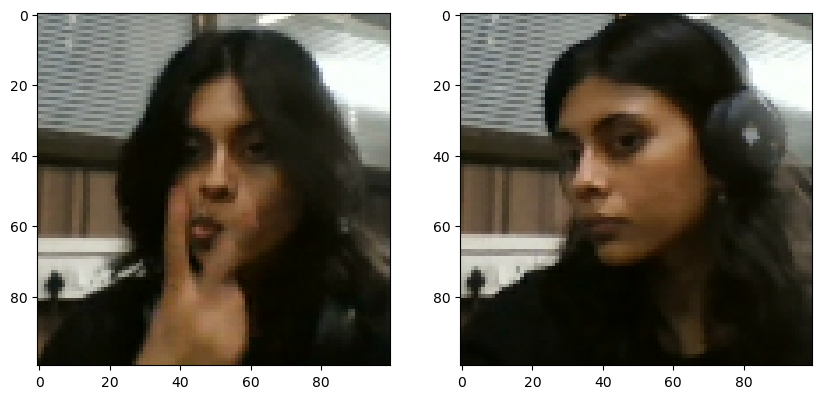

In [630]:

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[6])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

In [615]:
#save model
siamese_model.save('siamesemodel.h5')

In [617]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

#real time verify

In [636]:
def verify(model,detection_threshold,verification_threshold):
    results=[]
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img= preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_images',image))
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified        

In [640]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[200:450,200:450,:]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        #run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 146ms/step
True
1/1 [==============================] - 0s 143ms/step
False
